In [1]:
import datetime
import os
import sys
import time

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from astropy import convolution
import galsim
from galsim import roman
from galsim import InterpolatedImage, Image
import webbpsf

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import psf

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-067
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


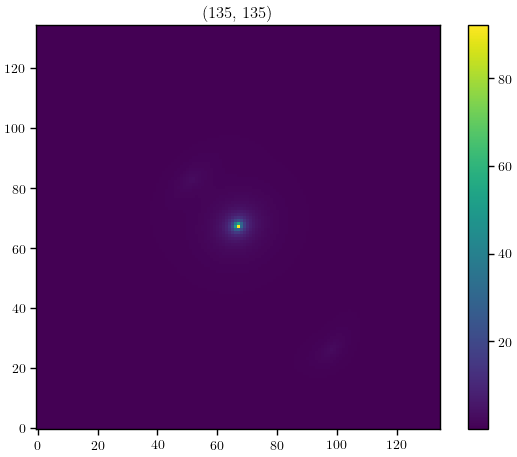

In [2]:
# pprint(roman.getBandpasses())
band = 'F129'
filter_name = 'J129'  # TODO use my translate method in gs and replace references
exposure_time = 146
oversample_factor = 3

lens = SampleStrongLens()
model = lens.get_array(num_pix=45 * oversample_factor, side=4.95, band=band)

model_side, _ = model.shape
plot.plot(model, colorbar=True, title=model.shape)

In [3]:
start = time.time()

# get flux
total_flux_cps = lens.get_total_flux_cps(band)
print(total_flux_cps)

4616.797781418052


In [4]:
roman_filters = roman.getBandpasses(AB_zeropoint=True)
pprint(roman_filters)
bandpass = roman_filters[filter_name]

detector = 1
detector_position = galsim.PositionD(2048, 2048)

ra_targ = galsim.Angle.from_hms('16:01:41.01257')
dec_targ = galsim.Angle.from_dms('66:48:10.1312')
targ_pos = galsim.CelestialCoord(ra=ra_targ, dec=dec_targ)

date = datetime.datetime(2025, 5, 16)

wcs_dict = roman.getWCS(world_pos=targ_pos, SCAs=detector, date=date)
wcs = wcs_dict[detector]

{'F184': galsim.Bandpass(galsim.LookupTable(x=array([1600.0, 1605.0, 1620.0, 1635.0, 1640.0, 1645.0, 1650.0, 1655.0, 1660.0, 1665.0, 1670.0, 1680.0, 1685.0, 1695.0, 1700.0, 1705.0, 1710.0, 1715.0, 1720.0, 1725.0, 1730.0, 1740.0, 1745.0, 1765.0, 1775.0, 1780.0, 1790.0, 1800.0, 1815.0, 1820.0, 1835.0, 1840.0, 1845.0, 1870.0, 1885.0, 1890.0, 1895.0, 1905.0, 1930.0, 1940.0, 1945.0, 1950.0, 1955.0, 1965.0, 1970.0, 1980.0, 1985.0, 2000.0, 2005.0, 2015.0000000000002, 2020.0, 2025.0, 2029.9999999999998, 2040.0, 2045.0, 2050.0, 2055.0, 2060.0, 2075.0, 2095.0, 2100.0]), f=array([0.0, 2.6616981634282673e-05, 0.0005057226510513708, 0.005456481235027948, 0.010726643598615917, 0.019856268299174872, 0.0347085440511046, 0.05743944636678201, 0.08999201490550972, 0.13377694969390475, 0.18898056960340698, 0.32637742879957415, 0.40170348682459417, 0.5420548309821667, 0.6, 0.6467926537130689, 0.682299707213202, 0.7075059888208677, 0.7247537929198828, 0.7354272025552302, 0.7417886611658238, 0.74764439712536

In [5]:
# get interpolated image
interp = InterpolatedImage(Image(model), scale=0.11 / oversample_factor, flux=total_flux_cps * exposure_time)

In [6]:
# inject sky background

# Also separately build up the sky image, which we need to get the noise right,
# even though we'll subtract off the expectation of the sky image.
sky_image = galsim.ImageF(45, 45, wcs=wcs)

# We have one rng for image-level stuff, and two others for the stars and galaxies.
# There are simpler ways to do this in a python script (e.g. probably only need 2
# rngs, not 3), but this way of setting it up matches the way the config file initializes
# the random number generators.
# Also, note that the second seed given in the config file, doesn't get the
# BaseDeviate(...).raw() treatment.  Only the first item, which parses as an int.
# When a random_seed config item is already a dict, GalSim leaves it as is.
image_rng = galsim.UniformDeviate(1)

# Start with the flux from the sky. This is a little easier to do first before adding
# the light from the objects, since we will have to apply Poisson noise to the sky flux
# manually, but the photon shooting will automatically include Poisson noise for the
# objects.

# First we get the amount of zodaical light for a position corresponding to the center of
# this SCA.  The results are provided in units of e-/arcsec^2, using the default Roman
# exposure time since we did not explicitly specify one.  Then we multiply this by a factor
# >1 to account for the amount of stray light that is expected.  If we do not provide a date
# for the observation, then it will assume that it's the vernal equinox (sun at (0,0) in
# ecliptic coordinates) in 2025.
SCA_cent_pos = wcs.toWorld(sky_image.true_center)
sky_level = roman.getSkyLevel(bandpass, world_pos=SCA_cent_pos, exptime=exposure_time)
sky_level *= (1.0 + roman.stray_light_fraction)
print(f'stray light fraction: {roman.stray_light_fraction}')
print(f'sky level: {sky_level}')

# Note that makeSkyImage() takes a bit of time. If you do not care about the variable pixel
# scale, you could simply compute an approximate sky level in e-/pix by multiplying
# sky_level by roman.pixel_scale**2, and add that to sky_image.
wcs.makeSkyImage(sky_image, sky_level)

stray light fraction: 0.1
sky level: 4405.347727237168


In [7]:
roman_bandpasses = galsim.roman.getBandpasses()
pprint(list(roman_bandpasses.keys()))

['R062', 'Z087', 'Y106', 'J129', 'H158', 'F184', 'W146', 'K213']


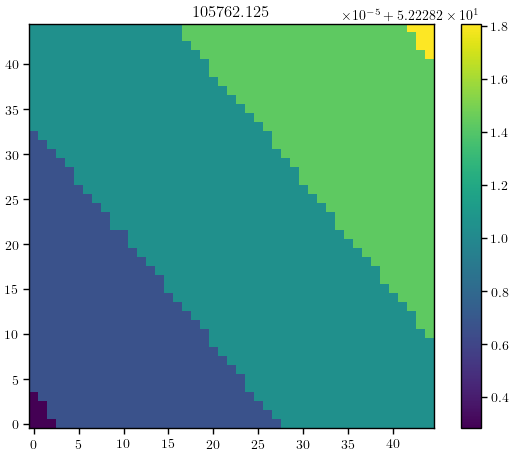

In [8]:
plot.plot(sky_image.array, colorbar=True, title=f'{sky_image.array.sum().sum()}')

In [9]:
# The other background is the expected thermal backgrounds in this band.
# These are provided in e-/pix/s, so we have to multiply by the exposure time.
print(f'thermal background for {filter_name}: {roman.thermal_backgrounds[filter_name]}')
thermal_bkg = roman.thermal_backgrounds[filter_name] * exposure_time
sky_image += thermal_bkg

thermal background for J129: 0.0


In [10]:
# poisson_noise = galsim.PoissonNoise(image_rng)
# sky_image.addNoise(poisson_noise)

# plot.plot(sky_image.array, colorbar=True, title=f'{sky_image.array.sum().sum()}')

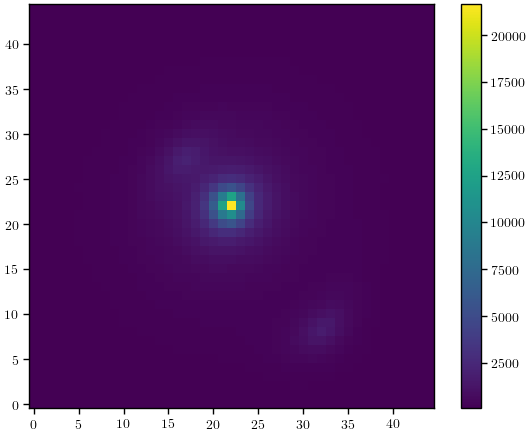

In [23]:
# somewhere in here, retrieve an off-axis PSF with WebbPSF, import as a galsim.InterpolatedImage, then convolve using a GalSim method
galsim_psf = roman.getPSF(detector, SCA_pos=detector_position, bandpass=None, wavelength=bandpass, pupil_bin=1)  # test with different pupil bin, 1 (4096x4096) is best but slowest, don't go any larger than 8 (512x512)

webb_psf = psf.get_webbpsf_psf(band, detector, (2048, 2048), oversample_factor, num_pix=45,
                                       check_cache=False, psf_cache_dir='/data/bwedig/mejiro/cached_psfs',
                                       suppress_output=False)

# https://galsim-developers.github.io/GalSim/_build/html/composite.html#galsim.Convolve
convolved = galsim.Convolve(interp, webb_psf)

# draw interpolated image
im = galsim.ImageF(45, 45, scale=0.11)
im.setOrigin(0, 0)
drawn = convolved.drawImage(im)

# add sky background
final_image = drawn + sky_image

# integer number of photons are being detected, so quantize
final_image.quantize()

plot.plot(final_image.array, colorbar=True)

In [24]:
# add all effects
# noise: Poisson noise due to signal (sky + background), dark current, read noise
# detector effects: reciprocity failure, quantization, persistence (assuming a list of previous exposures has been provided), nonlinearity, interpixel capacitance
prev_exposures = roman.allDetectorEffects(final_image, prev_exposures=(), rng=image_rng, exptime=exposure_time)

In [25]:
# quantize, as the analog-to-digital converter reads in an integer value
final_image.quantize()

# this has float values, so convert to integer values
final_image = galsim.Image(final_image, dtype=int)

In [26]:
np.save(os.path.join(array_dir, 'sample_skypy_lens', 'galsim.npy'), drawn.array)

stop = time.time()
execution_time = str(datetime.timedelta(seconds=round(stop - start)))
print(execution_time)

0:06:54


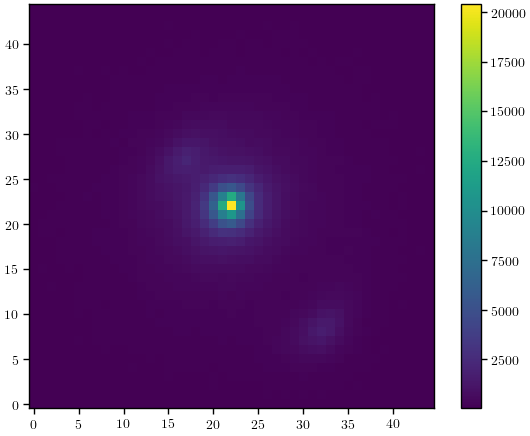

In [27]:
plot.plot(final_image.array, colorbar=True)

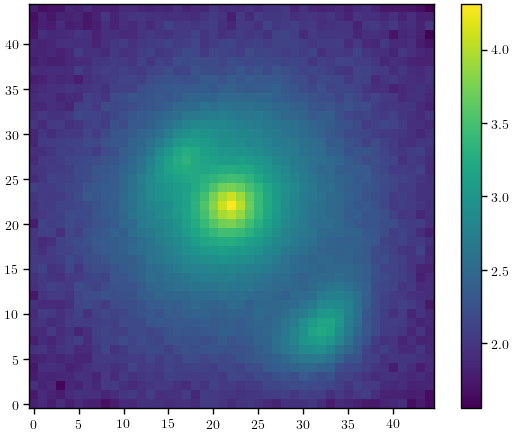

In [28]:
plt.imshow(np.log10(final_image.array))
plt.colorbar()
plt.show()